<h2>Initialize all imports</h2>

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import conda_installer
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import copy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import importlib
import keras.backend as K
# import tensorflow_addons as tfa
from tensorflow.keras import regularizers, constraints, callbacks

import sys
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

import time
import gc
from pathlib import Path
import matplotlib.ticker as mticker

2025-08-22 17:15:05.782146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-22 17:15:05.868432: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normaliz

## Read Input data & Change directory

In [2]:
# Depickle the PDB(Protein Data Bank) and read csv with data
PDBs = pickle.load(open('Datasets/PDBs_RDKit_BFE.pkl', 'rb'))
df = pd.read_csv('Datasets/Final_data_DDG.csv')


In [3]:
import models.layers_update_mobley as layers
from models.dcFeaturizer import atom_features as get_atom_features
importlib.reload(layers)
from models.PGCN_model_multiloss import get_trained_model, test_model

## Data pre-processing

In [4]:
# Iterate through each pdb. Look at current pdb position (row) and extract the information and store as a numpy array
# Note: Host is the receptor component which provides the binding site
# - Guest is the molecule that binds to the host
# - Complex is the bound state between guest and host and typically binding energy
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Ids'] == pdb][['pb_host_VDWAALS', 'pb_guest_VDWAALS', 'pb_complex_VDWAALS', 'gb_host_1-4EEL', 'gb_guest_1-4EEL', 'gb_Complex_1-4EEL',
       'gb_host_EELEC', 'gb_guest_EELEC', 'gb_Complex_EELEC', 'gb_host_EGB', 'gb_guest_EGB', 'gb_Complex_EGB', 'gb_host_ESURF', 'gb_guest_ESURF', 'gb_Complex_ESURF']].to_numpy()[0])

In [5]:
# Function takes in a molecule and information

def featurize(molecule, info):
    atom_features = []
    # Iterate through each atom
    for atom in molecule.GetAtoms():
        # List of features for the atom
        new_feature = get_atom_features(atom).tolist() 
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        # Store mass, atomic number, formal charge
        new_feature += [atom.GetMass(), atom.GetAtomicNum(),atom.GetFormalCharge()]
        # Store 3D position
        new_feature += [position.x, position.y, position.z]
        # Track neighboring atoms
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]

        atom_features.append(np.concatenate([new_feature, info], 0))
    return np.array(atom_features)

In [6]:
# X is the featurized molecule and y is the experimental binding free energy
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Ids'] == pdb]['Ex _G_(kcal/mol)'].to_numpy()[0])


[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValen

[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:15:21] DEPRECATION WARNING: please use GetValen

In [7]:
# Split the data into training and testing sets
# Randomly shuffles the data before splitting, ensuring that the training and testing sets are representative of the overall dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
len(X_train), len(X_test), len(y_train), len(y_test)


(57, 15, 57, 15)

## Helper Functions

<h3 style="color:red;">PCGrad Class</h3>

In [9]:
print(tf.__version__)

2.11.1


In [10]:
import tensorflow as tf
import numpy as np

class PCGrad(tf.keras.optimizers.Optimizer):
    def __init__(self, optimizer, name="PCGrad", **kwargs):
        # Change: Added this line to 'Remove learning_rate from kwards if present since new Keras doesnt accept it'
        kwargs.pop('learning_rate', None)
        # MUST be called first!
        super().__init__(name=name, **kwargs)
        self._optimizer = optimizer
    @property
    def learning_rate(self):
        return self._optimizer.learning_rate

    def apply_gradients(self, grads_and_vars, name=None, **kwargs):
        return self._optimizer.apply_gradients(grads_and_vars, name, **kwargs)
    
    # Rather than create slots and prepare we have now added a build function which builds the optimizer
    def build(self, var_list):
        """Build the optimizer"""
        super().build(var_list)
        if hasattr(self._optimizer, 'build'):
            self._optimizer.build(var_list)
            
    # Try without these first to replicate what was done        
    #def _create_slots(self, var_list):
    #    self._optimizer._create_slots(var_list)

    #def _prepare(self, var_list):
    #    self._optimizer._prepare(var_list)

    def get_config(self):
        config = super().get_config()
        config.update({"optimizer": tf.keras.optimizers.serialize(self._optimizer)})
        return config

    @classmethod
    def from_config(cls, config, custom_objects=None):
        optimizer_config = config.pop("optimizer")
        optimizer = tf.keras.optimizers.deserialize(optimizer_config, custom_objects=custom_objects)
        return cls(optimizer, **config)

    def compute_gradients(self, losses, tape, var_list, weights=None):
        """Compute PCGrad projected gradients from a list of task losses."""
        assert isinstance(losses, list), "loss must be a list of task losses"
        #grads_task = losses
        grads_task = []

        for loss in losses:
            grads = tape.gradient(loss, var_list)
             # This has also changed to weed out which gradients are presented as NaN and write a 0 in place
            for g in grads:
                if g is None:
                    print("Gradient is None")
            grads = [tf.zeros_like(v) if g is None else g for g, v in zip(grads, var_list)]
            grads_task.append(grads)

        # Flatten and apply projection
        def flatten(grads):
            return tf.concat([tf.reshape(g, [-1]) for g in grads], axis=0)

        flat_grads_task = [flatten(g) for g in grads_task]
        flat_grads_task = tf.stack(flat_grads_task)
        # Shuffle is so that it isn't biased towards only one gradient, sometimes it has to shuffle between gradients and pick different ones
        flat_grads_task = tf.random.shuffle(flat_grads_task)

        def project(g, others):
            for o in others:
                dot = tf.reduce_sum(g * o)
                if dot < 0:
                    g -= dot / (tf.reduce_sum(o * o) + 1e-12) * o
            return g

        projected = []
        for i in range(len(flat_grads_task)):
            others = tf.concat([flat_grads_task[:i], flat_grads_task[i+1:]], axis=0)
            projected.append(project(flat_grads_task[i], others))
        projected = tf.stack(projected)

        # Average the projected gradients and reshape
        #mean_grad = tf.reduce_mean(projected, axis=0)

        #reshaped_grads = []
        #idx = 0
        #for v in var_list:
        #    shape = tf.shape(v)
        #    size = tf.reduce_prod(shape)
        #    reshaped_grads.append(tf.reshape(mean_grad[idx:idx + size], shape))
        #    idx += size
            
        # New information I'm trying out: Unclear about what it does now !!! RESEARCH !!!
        # Apply weights after projection if provided (Option A)
        if weights is not None:
            weighted_projected = [w * p for w, p in zip(weights, projected)]
            mean_grad = tf.reduce_sum(tf.stack(weighted_projected), axis=0)
        else:
            # Average the projected gradients
            mean_grad = tf.reduce_mean(projected, axis=0)

        # Reshape gradient back to variable shapes
        reshaped_grads = []
        idx = 0
        for v in var_list:
            shape = tf.shape(v)
            size = tf.reduce_prod(shape)
            reshaped_grads.append(tf.reshape(mean_grad[idx:idx + size], shape))
            idx += size

        # Final sanitization of gradients
        reshaped_grads = [tf.where(tf.math.is_finite(g), g, tf.zeros_like(g)) for g in reshaped_grads]
        
        return list(zip(reshaped_grads, var_list))

In [11]:
opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=1e-3))

2025-08-22 17:15:24.996043: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-08-22 17:15:24.996094: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (curie.cluster): /proc/driver/nvidia/version does not exist
2025-08-22 17:15:24.998889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
class PGGCN_Hybrid(tf.keras.Model):
    # num_atom_features - number of features per atom
    # r_out_channel - number of output channels for graph convolutional layer (size of each output sample)
    # c_out_channel - number of output channels convolutional layer (size of each output sample)
    # l2 - regularization coefficient
    # drouput_rate - dropout rate for regularization (helps reduce overfitting)
    # maxnorm - norm constraint for the weight vectors
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128, l2=1e-4, dropout_rate=0.2, maxnorm=3.0):
        super().__init__()
        # Initialize RuleGraphConvLayer and set the out_channel to be 20 and number of features to be 36
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        # Initialize empty list of combination rules
        self.ruleGraphConvLayer.combination_rules = []
        # Initialize the Convolutional layer. Set the out_channel to be 128 and number of features as the other out_channel (20)
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        # Set the dense layer to 32 units, relu activation, use kernel regularizer l2 and use it as a bias regularizer, and add maxnorm constraint
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        # Set the dropout rate
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        # Set dense layer to 16 units and same activation, regularizer, and maxnorm constraint
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense6 = tf.keras.layers.Dense(1, name='dense6', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        # The weights have been manually set to a specific pattern based on the physics coefficients
        # Bias innitializers are set to 0 so there is no offset (rely on weights and features)
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([.3, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1]),
                                             bias_initializer=tf.keras.initializers.Zeros(),
                                             kernel_regularizer=regularizers.l2(l2), 
                                             bias_regularizer=regularizers.l2(l2), 
                                             kernel_constraint=constraints.MaxNorm(maxnorm))
        
        # For some reason self.i_s is set to None. Why are the input shapes set to None? We are initializing here?
        self.i_s = None

    # adds rule to RuleGraphConvLayer (see layers_update_mobley.py)
    def addRule(self, rule, start_index, end_index=None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    # It's internal and it's called everytime you call the class and sets the physics info and it's run through the labels 
    def call(self, inputs, training=True):
        print("Inside call")
        physics_info = inputs[:, 0, 38:]
        #x_a = [inputs[i, :, :38] for i in range(tf.shape(inputs)[0])]

        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense5(x)
        x = self.dropout2(x, training=training)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return tf.concat([out, physics_info], axis=1)
    
empirical_loss_value = tf.Variable(0.0, trainable=False, dtype=tf.float32)
physics_loss_value = tf.Variable(0.0, trainable=False, dtype=tf.float32)

# Callback function which displays empirical loss, physical loss, totall loss and learning rates for each epoch
class LossComponentsCallback_Hybrid(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.empirical_losses = []
        self.physical_losses = []
        self.total_losses = []
        self.learning_rates = []
        self.model_instance = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model_instance.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))
        self.empirical_losses.append(float(empirical_loss_value.numpy()))
        self.physical_losses.append(float(physics_loss_value.numpy()))
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model_instance.optimizer.iterations)  # Call the schedule
        else:
            lr = lr  

        self.learning_rates.append(float(tf.keras.backend.get_value(lr)))


def pure_rmse_hybrid(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    return K.sqrt(K.mean(K.square(y_pred - y_true_flat)))

def physical_consistency_loss(y_true,y_pred,physics_info):
    dG_pred = y_pred
    y_true = tf.reshape(y_true, (-1, 1))

    # Physical Inconsistency loss
    # Extract the components from physics_info
    host = tf.gather(physics_info, [0, 3, 6, 9, 12], axis=1)  # Host energy terms
    guest = tf.gather(physics_info, [1, 4, 7, 10, 13], axis=1)  # Guest energy terms
    complex_ = tf.gather(physics_info, [2, 5, 8, 11, 14], axis=1)  # Complex energy terms

    # Calculate ΔG based on physics: ΔG = ΔGcomplex - (ΔGhost + ΔGguest)
    dG_physics = tf.reduce_sum(complex_, axis=1, keepdims=True) - (tf.reduce_sum(host, axis=1, keepdims=True) + tf.reduce_sum(guest, axis=1, keepdims=True))
    phy_loss = K.sqrt(K.mean(K.square(dG_pred - dG_physics)))
    

    return phy_loss


# Output of the empirical loss is going to be a tensor and we have to convert it into a number value
def combined_loss(physics_hyperparam=0.0003):
    
    def loss_function(y_true, y_pred):
        # Extract prediction and physics info
        prediction = y_pred[:, 0]
        physics_info = y_pred[:, 1:16]  # Assuming 15 physical features
        
        # Calculate individual loss components
        empirical_loss = pure_rmse_hybrid(y_true, prediction)
        physics_loss = physical_consistency_loss(y_true, prediction, physics_info)
        
        # Append losses to a list and return
        losses = []
        losses.append(empirical_loss)
        losses.append(physics_loss)
        
        # Keep track each of the loss values. Total loss is returned
        # The value ones are logs for the history
        total_loss = empirical_loss + (physics_hyperparam * physics_loss)
        empirical_loss_value.assign(empirical_loss)
        physics_loss_value.assign(physics_loss) 

        return total_loss
    
    return loss_function

# Debugging utilities
def report_none_grads(grads, vars, tag):
    none_idx = [i for i,(g,_) in enumerate(zip(grads, vars)) if g is None]
    if none_idx:
        names = [vars[i].name for i in none_idx]
        print(f"[{tag}] None gradients on {len(none_idx)} vars:")
        for n in names[:10]:
            print("  -", n)
    else:
        print(f"[{tag}] No None gradients")

In [13]:
#physics_hyperparam = [0.005]
epochs = [250]
#lr_schedule = ExponentialDecay(
#        initial_learning_rate=0.005,
#        decay_steps=10000,
#        decay_rate=0.9,
#        staircase=True
#    )
results = {}
y_differences = []
total_losses = []
empirical_losses = []
physics_losses = []
all_results=[]
    
outdir = Path("05_difference_runs")
outdir.mkdir(parents=True, exist_ok=True)

<h3>BFE Loss Function with PCGrad and Grid Search</h3>

In [14]:
# Run search function - optimized version
def run_search(physics_weight, X_train, X_test, y_train, y_test, epochs=250):
    # Aggressive session clearing
    tf.keras.backend.clear_session()
    gc.collect()
    
    start_time = time.time()
    print(f"---------- Physics Weight: {physics_weight} ------------")

    # Create fresh copies of data
    X_train_copy = copy.deepcopy(X_train)
    X_test_copy = copy.deepcopy(X_test)
    y_train_copy = copy.deepcopy(y_train)
    y_test_copy = copy.deepcopy(y_test)

    # Create NEW model instance (critical!)
    print("Creating fresh model...")
    m = PGGCN_Hybrid()
    m.addRule("sum", 0, 32)
    m.addRule("multiply", 32, 33)
    m.addRule("distance", 33, 36)

    # Use a fresh optimizer with different random seed
    # lr_schedule = ExponentialDecay(
    #     initial_learning_rate=0.005,
    #     decay_steps=10000,
    #     decay_rate=0.9,
    #     staircase=True
    # )

    # lr_schedule = ExponentialDecay(
    #     initial_learning_rate=0.005,
    #     decay_steps=10000,
    #     decay_rate=0.9,
    #     staircase=True
    # )
    lr_schedule = 1e-4
    tf.random.set_seed(int(physics_weight * 10000))  # Different seed per weight
    opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=lr_schedule))

    input_shapes = [X.shape[0] for X in X_train_copy]
    m.set_input_shapes(input_shapes)
    
    # Pad training data
    for i in range(len(X_train_copy)):
        if X_train_copy[i].shape[0] < 2000:
            X_train_copy[i] = np.concatenate([X_train_copy[i], np.zeros([2000 - X_train_copy[i].shape[0], 53])], axis=0)

    # Pad test data
    for i in range(len(X_test_copy)):
        if X_test_copy[i].shape[0] < 2000:
            X_test_copy[i] = np.concatenate([X_test_copy[i], np.zeros([2000 - X_test_copy[i].shape[0], 53])], axis=0)

    # Convert to same type
    X_train_copy = np.array(X_train_copy).astype(np.float32)
    y_train_copy = np.array(y_train_copy).astype(np.float32)
    X_test_copy = np.array(X_test_copy).astype(np.float32)
    y_test_copy = np.array(y_test_copy).astype(np.float32)

    print(f"Training data shape: {X_train_copy.shape}")
    print(f"Test data shape: {X_test_copy.shape}")

    total_losses = []
    empirical_losses = []
    physics_losses = []

    # Early stopping
    best_train_loss = float("inf")
    patience = 15
    patience_counter = 0
    min_delta = 0.001
    best_weights = None

    print("Starting training...")
    training_start = time.time()

    # Training loop with optimizations
    for ep in range(epochs):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(m.trainable_variables)
            predictions = m(X_train_copy, training=True)
            
            # Calculate losses
            emp_loss = pure_rmse_hybrid(y_train_copy, predictions[:, 0])
            phy_loss = physical_consistency_loss(y_train_copy, predictions[:, 0], predictions[:, 1:16])
            total_loss = emp_loss + physics_weight * phy_loss

        # Apply gradients using Option A (weight after projection)
        weights_vec = [1.0, float(physics_weight)]
        grads_and_vars = opt.compute_gradients([emp_loss, phy_loss], tape, m.trainable_variables, weights=weights_vec)
        opt.apply_gradients(grads_and_vars)

        # Store losses
        current_total_loss = float(total_loss.numpy())
        total_losses.append(current_total_loss)
        empirical_losses.append(float(emp_loss.numpy()))
        physics_losses.append(float(phy_loss.numpy()))

        # Early stopping logic
        if current_total_loss + min_delta < best_train_loss:
            best_train_loss = current_total_loss
            best_weights = m.get_weights()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {ep + 1}")
                break

        # Print progress every 50 epochs to reduce overhead
        if (ep + 1) % 50 == 0 or ep == 0:
            print(f"Epoch {ep + 1}/{epochs} - Total: {current_total_loss:.4f}, "
                  f"Empirical: {emp_loss.numpy():.4f}, Physics: {phy_loss.numpy():.4f}")
    
    training_time = time.time() - training_start
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Restore best weights
    if best_weights is not None:
        m.set_weights(best_weights)
        print("Restored best weights from training")

    # Evaluation phase
    print("Starting evaluation...")
    eval_start = time.time()
    
    # Initialize prediction list
    y_pred_test = []
    
    # Make predictions
    for i in range(len(X_test_copy)):
        try:
            m.set_input_shapes([X_test_copy[i].shape[0]])
            pred = m(X_test_copy[i][np.newaxis, ...], training=False)
            pred_value = float(pred[0, 0].numpy())
            y_pred_test.append(pred_value)
        except Exception as e:
            print(f"Warning: Prediction {i} failed: {e}")
            y_pred_test.append(0.0)  # Default value
    
    y_pred_test = np.array(y_pred_test)
    eval_time = time.time() - eval_start
    
    print(f"Evaluation completed in {eval_time:.2f} seconds")
    print(f"Predictions shape: {y_pred_test.shape}")
    print(f"Predictions range: [{y_pred_test.min():.4f}, {y_pred_test.max():.4f}]")
    print(f"True values range: [{y_test_copy.min():.4f}, {y_test_copy.max():.4f}]")
    
    # Calculate metrics
    MAD = np.mean(np.abs((y_test_copy) - (y_pred_test)))
    # Calculate MAD without inner np.abs (mean of the signed differences)
  
    test_emp_loss = pure_rmse_hybrid(y_test_copy, y_pred_test)
    test_phy_loss = physical_consistency_loss(y_test_copy, y_pred_test, X_test_copy[:, 0, 38:53])
    test_loss = test_emp_loss + physics_weight * test_phy_loss

    end_time = time.time()
    elapsed = end_time - start_time
    
    print(f"Total time: {elapsed:.2f} seconds ({elapsed/60:.1f} minutes)")
    print(f"MAD (mean of abd differences): {MAD:.6f}")
    print(f"Test empirical loss: {float(test_emp_loss.numpy()):.6f}")
    print(f"Test physics loss: {float(test_phy_loss.numpy()):.6f}")
    print(f"Test total loss: {float(test_loss.numpy()):.6f}")

    result_temp = {
        'name': 'ΔΔG with Multi-Loss',
        'y_test': y_test_copy,
        'test_loss': float(test_loss.numpy()),
        'test_emp_loss': float(test_emp_loss.numpy()),
        'test_phy_loss': float(test_phy_loss.numpy()),
        'y_pred_test': y_pred_test,
        'MAD': MAD,
        'all_losses': total_losses,
        'empirical_losses': empirical_losses,
        'physical_losses': physics_losses,
        'training_time': training_time,
        'eval_time': eval_time,
        'total_time': elapsed,
        'hyperparameters': {
            'physics_weight': physics_weight,
            'epochs': ep + 1 if best_weights is not None else epochs,
            'initial_learning_rate': 0.005,
            'decay_steps': 10000,
            'decay_rate': 0.9
        }
    }

    # Create plots with more detail
    plt.figure(figsize=(15, 12))
    
    # Total Loss Graph
    plt.subplot(3, 3, 1)
    plt.plot(range(1, len(total_losses) + 1), total_losses, 'b-', label='Total Loss', linewidth=2)
    plt.title(f'Total Loss (λ: {physics_weight})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Empirical Loss Graph
    plt.subplot(3, 3, 2)
    plt.plot(range(1, len(empirical_losses) + 1), empirical_losses, 'r-', label='Empirical Loss', linewidth=2)
    plt.title(f'Empirical Loss (λ: {physics_weight})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Physics Loss Graph
    plt.subplot(3, 3, 3)
    plt.plot(range(1, len(physics_losses) + 1), physics_losses, 'g-', label='Physics Loss', linewidth=2)
    plt.title(f'Physics Loss (λ: {physics_weight})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # MAD Graph
    plt.subplot(3, 3, 4)
    plt.scatter(y_test_copy, y_pred_test, alpha=0.7, s=50)
    plt.plot([y_test_copy.min(), y_test_copy.max()], [y_test_copy.min(), y_test_copy.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'True vs Predicted (MAD: {MAD:.4f}, λ: {physics_weight})')
    plt.grid(True, alpha=0.3)
    
    filename = outdir / f"results_physics_weight_{physics_weight}.png"
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

    # Explicit cleanup
    del m, X_train_copy, X_test_copy, y_train_copy
    gc.collect()
    
    return result_temp

In [15]:
def run_full_grid_search(X_train, X_test, y_train, y_test, weights=[round(x * 0.05, 2) for x in range(21)]):
    results = {}
    all_results = []
    best_loss = float('inf')
    best_result = None

    print("Starting optimized grid search...")
    print(f"Testing {len(weights)} physics weights: {weights}")
    
    for i, w in enumerate(weights):
        print(f"\n{'='*70}")
        print(f"PROGRESS: {i+1}/{len(weights)} - Testing physics weight: {w}")
        print(f"{'='*70}")
        
        try:
            result = run_search(w, X_train, X_test, y_train, y_test)
            all_results.append(result)
            results[f"w_{w}"] = result
            
            # Track best result
            if result['test_loss'] < best_loss:
                best_loss = result['test_loss']
                best_result = result
                print(f"NEW BEST RESULT! Test loss: {best_loss:.6f}")
            
            print(f"Completed {w} successfully")
            
        except Exception as e:
            print(f"ERROR with physics weight {w}: {e}")
            # Store error info
            error_result = {
                'name': 'ERROR',
                'test_loss': float('inf'),
                'test_emp_loss': float('inf'),
                'test_phy_loss': float('inf'),
                'MAD': float('inf'),
                'error': str(e),
                'hyperparameters': {'physics_weight': w, 'epochs': 0}
            }
            all_results.append(error_result)
            continue

    print(f"\n{'='*70}")
    print("FINAL GRID SEARCH RESULTS")
    print(f"{'='*70}")

    if best_result and best_result['name'] != 'ERROR':
        print("BEST CONFIGURATION:")
        print(f"   Physics weight: {best_result['hyperparameters']['physics_weight']}")
        print(f"   Test loss: {best_result['test_loss']:.6f}")
        print(f"   Test empirical loss: {best_result['test_emp_loss']:.6f}")
        print(f"   Test physics loss: {best_result['test_phy_loss']:.6f}")
        print(f"   MAD: {best_result['MAD']:.6f}")
        print(f"   Epochs completed: {best_result['hyperparameters']['epochs']}")
        print(f"   Training time: {best_result['training_time']:.1f}s")
        
        print("\nCOMPLETE RESULTS RANKING:")
        # Sort results by test loss
        successful_results = [r for r in all_results if r['name'] != 'ERROR']
        successful_results.sort(key=lambda x: x['test_loss'])
        
        # Print table header
        print(f"   {'Rank':<4} {'Weight':<8} {'Loss':<10} {'Emp.Loss':<10} {'Phy.Loss':<10} {'MAD':<10} {'Epochs':<6} {'Time(s)':<8}")
        print(f"   {'-'*4} {'-'*8} {'-'*10} {'-'*10} {'-'*10} {'-'*10} {'-'*6} {'-'*8}")
        
        # Print each result
        for rank, result in enumerate(successful_results, 1):
            pw = result['hyperparameters']['physics_weight']
            tl = result['test_loss']
            emp_loss = result['test_emp_loss']
            phy_loss = result['test_phy_loss']
            mad = result['MAD']
            ep = result['hyperparameters']['epochs']
            tt = result['training_time']
            print(f"   {rank:<4} {pw:<8.4f} {tl:<10.6f} {emp_loss:<10.6f} {phy_loss:<10.6f} {mad:<10.6f} {ep:<6d} {tt:<8.1f}")
        
        # Show failed runs
        failed_results = [r for r in all_results if r['name'] == 'ERROR']
        if failed_results:
            print("\nFAILED RUNS:")
            for result in failed_results:
                pw = result['hyperparameters']['physics_weight']
                error = result.get('error', 'Unknown error')
                print(f"   Weight={pw}: {error}")
        
        # Create comparison plot if multiple successful results
        if len(successful_results) > 1:
            create_comparison_plots(successful_results, best_result)
    else:
        print("NO SUCCESSFUL RESULTS FOUND!")
        print("All runs failed. Check your model and data.")

    return best_result, all_results, results

In [16]:
def create_comparison_plots(successful_results, best_result):
    plt.figure(figsize=(15, 12))  # Increased height to accommodate new plot
    
    # Loss comparison
    plt.subplot(3, 3, 1)
    weights_plot = [r['hyperparameters']['physics_weight'] for r in successful_results]
    losses_plot = [r['test_loss'] for r in successful_results]
    plt.plot(weights_plot, losses_plot, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Physics Weight')
    plt.ylabel('Test Loss')
    plt.title('Test Loss vs Physics Weight')
    plt.grid(True, alpha=0.3)
    
    # Empirical Loss comparison
    plt.subplot(3, 3, 2)
    emp_losses_plot = [r['test_emp_loss'] for r in successful_results]
    plt.plot(weights_plot, emp_losses_plot, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Physics Weight')
    plt.ylabel('Empirical Loss')
    plt.title('Empirical Loss vs Physics Weight')
    plt.grid(True, alpha=0.3)
    
    # Physics Loss comparison
    plt.subplot(3, 3, 3)
    phy_losses_plot = [r['test_phy_loss'] for r in successful_results]
    plt.plot(weights_plot, phy_losses_plot, 'go-', linewidth=2, markersize=8)
    plt.xlabel('Physics Weight')
    plt.ylabel('Physics Loss')
    plt.title('Physics Loss vs Physics Weight')
    plt.grid(True, alpha=0.3)
    
    # MAD comparison
    plt.subplot(3, 3, 4)
    mad_plot = [r['MAD'] for r in successful_results]
    plt.plot(weights_plot, mad_plot, 'mo-', linewidth=2, markersize=8)
    plt.xlabel('Physics Weight')
    plt.ylabel('MAD')
    plt.title('MAD vs Physics Weight')
    plt.grid(True, alpha=0.3)
    
    # Training time comparison
    plt.subplot(3, 3, 5)
    time_plot = [r['training_time']/60 for r in successful_results]  # Convert to minutes
    plt.plot(weights_plot, time_plot, 'co-', linewidth=2, markersize=8)
    plt.xlabel('Physics Weight')
    plt.ylabel('Training Time (minutes)')
    plt.title('Training Time vs Physics Weight')
    plt.grid(True, alpha=0.3)
    
    # Best model loss curves
    plt.subplot(3, 3, 6)
    if 'all_losses' in best_result:
        plt.plot(best_result['all_losses'], 'b-', label='Total', linewidth=2)
        plt.plot(best_result['empirical_losses'], 'r-', label='Empirical', linewidth=2)
        plt.plot(best_result['physical_losses'], 'g-', label='Physics', linewidth=2)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Best Model Loss Curves\n(Weight: {best_result["hyperparameters"]["physics_weight"]})')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Best model predictions
    plt.subplot(3, 3, 7)
    plt.scatter(best_result['y_test'], best_result['y_pred_test'], alpha=0.7, s=50)
    min_val = min(best_result['y_test'].min(), best_result['y_pred_test'].min())
    max_val = max(best_result['y_test'].max(), best_result['y_pred_test'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Best Model: True vs Predicted\n(MAD: {best_result["MAD"]:.4f})')
    plt.grid(True, alpha=0.3)
    
    # Physics vs Empirical Loss scatter plot
    plt.subplot(3, 3, 8)
    emp_values = [r['test_emp_loss'] for r in successful_results]
    phy_values = [r['test_phy_loss'] for r in successful_results]
    plt.scatter(emp_values, phy_values, alpha=0.7, s=80, c='purple')
    
    # Add weight labels to each point
    for i, weight in enumerate(weights_plot):
        plt.annotate(f"{weight:.4f}", 
                     (emp_values[i], phy_values[i]),
                     xytext=(5, 5),
                     textcoords="offset points")
    
    plt.xlabel('Empirical Loss')
    plt.ylabel('Physics Loss')
    plt.title('Empirical vs Physics Loss')
    plt.grid(True, alpha=0.3)
    
    # Performance summary
    plt.subplot(3, 3, 9)
    components = ['Test Loss', 'Emp. Loss', 'Phy. Loss', 'MAD', 'Time (min)']
    values = [
        best_result['test_loss'], 
        best_result['test_emp_loss'],
        best_result['test_phy_loss'],
        best_result['MAD'], 
        best_result['training_time']/60
    ]
    colors = ['blue', 'red', 'green', 'magenta', 'cyan']
    bars = plt.bar(components, values, color=colors, alpha=0.7)
    plt.title('Best Model Metrics')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('grid_search_comparison.png')
    plt.close()

In [17]:
# Two-step gradient debugging function
def debug_gradients(X_train, y_train, layers_module):
    print("=== Two-step gradient debug (Adam only) ===")

    # Fresh small model and data copies
    _dbg_m = PGGCN_Hybrid()
    _dbg_m.addRule("sum", 0, 32)
    _dbg_m.addRule("multiply", 32, 33)
    _dbg_m.addRule("distance", 33, 36)

    # Prepare one-batch dataset
    _dbg_X = [np.copy(x) for x in X_train]
    for i in range(len(_dbg_X)):
        if _dbg_X[i].shape[0] < 2000:
            _dbg_X[i] = np.concatenate([_dbg_X[i], np.zeros([2000 - _dbg_X[i].shape[0], 53])], axis=0)
    _dbg_X = np.array(_dbg_X).astype(np.float32)
    _dbg_y = np.array(y_train).astype(np.float32)

    _dbg_m.set_input_shapes([x.shape[0] for x in _dbg_X])
    _dbg_opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

    # Step 0: forward only checks
    with tf.GradientTape(persistent=True) as tape0:
        tape0.watch(_dbg_m.trainable_variables)
        preds0 = _dbg_m(_dbg_X, training=True)
        emp0 = pure_rmse_hybrid(_dbg_y, preds0[:,0])
        phy0 = physical_consistency_loss(_dbg_y, preds0[:,0], preds0[:,1:16])
        tot0 = emp0 + 0.001*phy0

    print("preds0 shape:", preds0.shape, "dtype:", preds0.dtype)
    print("emp0:", float(emp0.numpy()), "phy0:", float(phy0.numpy()), "tot0:", float(tot0.numpy()))
    print("has_nan preds:", bool(tf.reduce_any(tf.math.is_nan(preds0))))
    print("has_inf preds:", bool(tf.reduce_any(tf.math.is_inf(preds0))))

    # Gradients at step 0
    grads0 = tape0.gradient([emp0, 0.001*phy0], _dbg_m.trainable_variables)
    if isinstance(grads0[0], (list, tuple)):
        _gflat = []
        for g in grads0:
            _gflat.append(g)
        grads0 = _gflat
    report_none_grads(grads0, _dbg_m.trainable_variables, "step0")

    # Apply one update with Adam to see if variables break gradient flow
    _dbg_opt.apply_gradients([(g, v) for g, v in zip(grads0, _dbg_m.trainable_variables) if g is not None])

    # Step 1: recompute on updated weights
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch(_dbg_m.trainable_variables)
        preds1 = _dbg_m(_dbg_X, training=True)
        emp1 = pure_rmse_hybrid(_dbg_y, preds1[:,0])
        phy1 = physical_consistency_loss(_dbg_y, preds1[:,0], preds1[:,1:16])
        tot1 = emp1 + 0.001*phy1

    print("preds1 shape:", preds1.shape, "dtype:", preds1.dtype)
    print("emp1:", float(emp1.numpy()), "phy1:", float(phy1.numpy()), "tot1:", float(tot1.numpy()))
    print("has_nan preds1:", bool(tf.reduce_any(tf.math.is_nan(preds1))))
    print("has_inf preds1:", bool(tf.reduce_any(tf.math.is_inf(preds1))))

    # Gradients at step 1
    grads1 = tape1.gradient([emp1, 0.001*phy1], _dbg_m.trainable_variables)
    report_none_grads(grads1, _dbg_m.trainable_variables, "step1")

    print("=== End two-step gradient debug ===")
    return

In [18]:
# Load data
print("Loading data...")
#PDBs, df = load_data()
    
# Import custom modules
print("Importing custom modules...")
#layers_module, get_atom_features = import_custom_modules()
#layers and get+atom_features
    
# Preprocess data
print("Preprocessing data...")
#info = extract_info(PDBs, df)
#X, y, X_train, X_test, y_train, y_test = prepare_data(PDBs, df, info, get_atom_features)
    
print(f"Dataset sizes: {len(X_train)} training, {len(X_test)} testing")
    
# # Debug gradients
# debug_gradients(X_train, y_train, layers_module)
    
# Run grid search
print("STARTING OPTIMIZED GRID SEARCH")
print("=" * 70)
weights = [round(x * 0.05, 2) for x in range(21)]
best_result, all_results, results = run_full_grid_search(X_train, X_test, y_train, y_test, weights)
    
# Save results
with open('grid_search_results_05.pkl', 'wb') as f:
    pickle.dump({
        'best_result': best_result,
        'all_results': all_results,
        'results': results
    }, f)
    
print("Results saved to grid_search_results_05.pkl")
print("Script execution completed!")

Loading data...
Importing custom modules...
Preprocessing data...
Dataset sizes: 57 training, 15 testing
STARTING OPTIMIZED GRID SEARCH
Starting optimized grid search...
Testing 21 physics weights: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

PROGRESS: 1/21 - Testing physics weight: 0.0
---------- Physics Weight: 0.0 ------------
Creating fresh model...
Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/250 - Total: 8.9546, Empirical: 8.9546, Physics: 26.1366
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
I

Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Early stopping triggered at epoch 135
Training completed in 469.59 seconds
Restored best weights from training
Starting evaluation...
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Evaluation completed in 1.82 seconds
Predictions shape: (15,)
Predictions range: [-4.3368, 7.1633]
True values range: [1.4580, 5.0400]
Total time: 471.54 seconds (7.9 minutes)
MAD (mean of abd differences): 3.004213
Test empirical loss: 3.689616
Test physics loss: 13.123222
Test total loss: 4.345777
Completed 0.05 successfully

PROGRESS: 3/21 - Testing physics weight: 0.1
---------- Physics Weight: 0.1 ----

Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 100/250 - Total: 6.9353, Empirical: 3.3709, Physics: 17.8223
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 150/250 - Total: 6.7598, Empirical: 3.3323, Physics: 17.1377
Inside call
Inside call
In

Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 50/250 - Total: 9.9274, Empirical: 4.1496, Physics: 19.2592
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 100/250 - Total: 8.6897, Empirical: 3.4637, Physics: 17.4201
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Ins

Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 50/250 - Total: 11.8834, Empirical: 4.1613, Physics: 19.3050
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside ca

Completed 0.45 successfully

PROGRESS: 11/21 - Testing physics weight: 0.5
---------- Physics Weight: 0.5 ------------
Creating fresh model...
Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call
Epoch 1/250 - Total: 22.0229, Empirical: 8.9546, Physics: 26.1366
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 50/250 - Total: 13.8232, Empirical: 4.1598, Physics: 19.3268
Inside call
Inside call
Inside call

Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Evaluation completed in 1.86 seconds
Predictions shape: (15,)
Predictions range: [-4.2630, 8.3405]
True values range: [1.4580, 5.0400]
Total time: 908.28 seconds (15.1 minutes)
MAD (mean of abd differences): 3.063627
Test empirical loss: 3.702454
Test physics loss: 12.703818
Test total loss: 10.689554
Completed 0.55 successfully

PROGRESS: 13/21 - Testing physics weight: 0.6
---------- Physics Weight: 0.6 ------------
Creating fresh model...
Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call
Epoch 1/250 - Total: 24.6366, Empirical: 8.9546, Physics: 26.1366
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Ins

Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 250/250 - Total: 14.3249, Empirical: 3.2065, Physics: 17.1053
Training completed in 889.01 seconds
Restored best weights from training
Starting evaluation...
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Evaluation completed in 1.87 seconds
Predictions shape: (15,)
Predictions range: [-4.0425, 8.5844]
True values range: [1.4580, 5.0400]
Total time: 891.73 seconds (14.9 minutes)
MAD (mean of abd differences): 2.940990
Test empirical loss: 3.578863
Test physics loss: 12.899194
Test total loss: 11.963339
Compl

Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 200/250 - Total: 16.0639, Empirical: 3.3146, Physics: 16.9991
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 250/250 - Total: 16.0135, Empirical: 3.2792, Physics: 16.9791
Training completed in 891.26 seconds
Restored best weights f

Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 150/250 - Total: 17.8599, Empirical: 3.3312, Physics: 17.0926
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 200/250 - Total: 17.7705, Empirical: 3.2961, Physics: 17.0287
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call


Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 150/250 - Total: 19.5994, Empirical: 3.2907, Physics: 17.1670
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside c

Results saved to grid_search_results_05.pkl
Script execution completed!


<h3>Pareto Front Graph</h3>

In [14]:
with open(outdir / "grid_search_results_05.pkl", "rb") as f:
    saved = pickle.load(f)

#best_result = saved["best_result"]
all_results = saved["all_results"]
results = saved["results"]

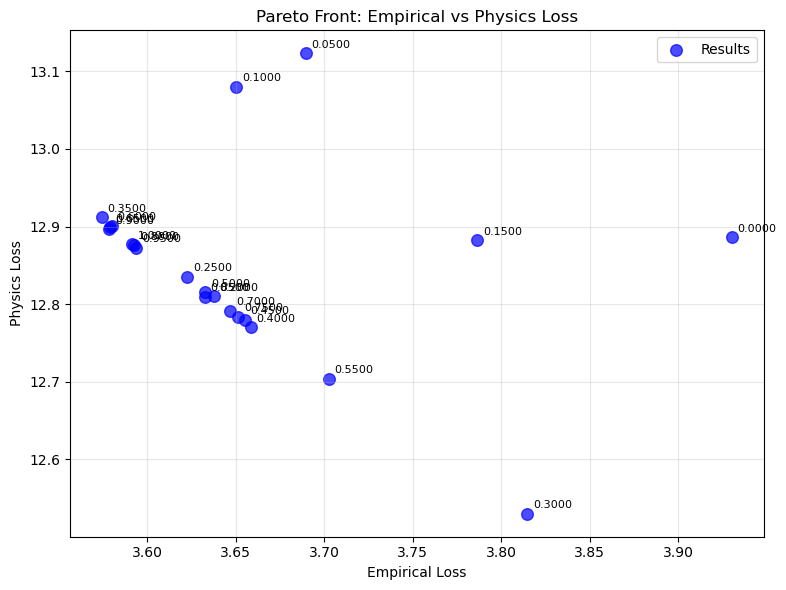

In [15]:
def create_pareto_plot(successful_results, best_result=None, save_path="pareto_front_05.png"):
    """
    Creates a Pareto front plot using empirical and physics loss from the successful runs.

    Parameters:
        successful_results (list): List of result dicts returned from run_search().
        best_result (dict): The best result to highlight (optional).
        save_path (str): Where to save the figure.
    """
    # Extract data
    emp_losses = np.array([r['test_emp_loss'] for r in successful_results])
    phy_losses = np.array([r['test_phy_loss'] for r in successful_results])
    weights = [r['hyperparameters']['physics_weight'] for r in successful_results]

    # Plot points
    plt.figure(figsize=(8, 6))
    plt.scatter(emp_losses, phy_losses, s=70, c='blue', alpha=0.7, label='Results')

    # Annotate weights
    for i, w in enumerate(weights):
        plt.annotate(f"{w:.4f}", (emp_losses[i], phy_losses[i]), fontsize=8, xytext=(4, 4), textcoords='offset points')

    # Draw connecting polyline (sorted by emp loss)
    #sorted_idx = np.argsort(emp_losses)
    #plt.plot(emp_losses[sorted_idx], phy_losses[sorted_idx], 'b--', lw=1.5, alpha=0.5)

    # Highlight best result
    if best_result:
        best_emp = best_result['test_emp_loss']
        best_phy = best_result['test_phy_loss']
        best_weight = best_result['hyperparameters']['physics_weight']
        plt.scatter(best_emp, best_phy, s=140, facecolors='none', edgecolors='red', linewidths=2,
                    label=f'Best (λ={best_weight:.4f})')
        plt.annotate("Best", (best_emp, best_phy), fontsize=10, fontweight='bold',
                     xytext=(8, -10), textcoords='offset points', color='red')

    # Formatting
    plt.xlabel("Empirical Loss")
    plt.ylabel("Physics Loss")
    plt.title("Pareto Front: Empirical vs Physics Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

    
create_pareto_plot(all_results)

In [16]:
best_result_pareto = 0.55

# Extract data from pkl file for selected weight
weight_data = min(all_results, key=lambda r: abs(r['hyperparameters']['physics_weight'] - best_result_pareto))
pcgrad_emp_losses = weight_data['empirical_losses']
pcgrad_phy_losses = weight_data['physical_losses']
pcgrad_MAD = weight_data['MAD']

print(len(pcgrad_emp_losses))

250


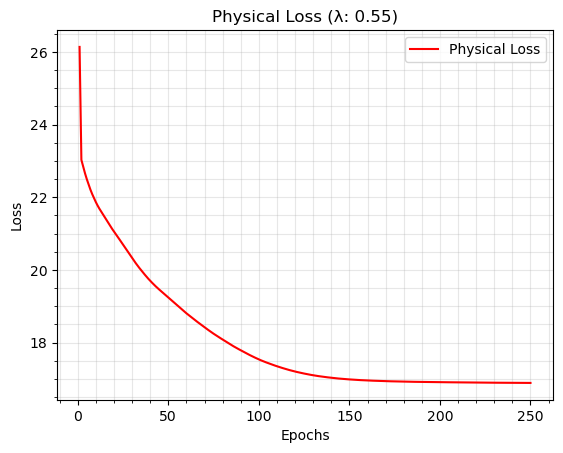

In [17]:
# Physical Loss
plt.subplot(1, 1, 1)
plt.plot(range(1, len(pcgrad_phy_losses) + 1), pcgrad_phy_losses, 'r', label='Physical Loss')
plt.title(f'Physical Loss (λ: {best_result_pareto})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, which='both', alpha=0.3)
plt.minorticks_on()
plt.legend()

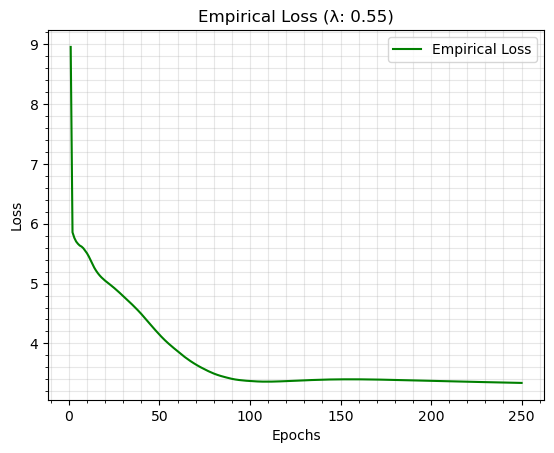

In [18]:
# Empirical Loss
plt.subplot(1, 1, 1)
plt.plot(range(1, len(pcgrad_emp_losses) + 1), pcgrad_emp_losses, 'g', label='Empirical Loss')
plt.title(f'Empirical Loss (λ: {best_result_pareto})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, which='both', alpha=0.3)
plt.minorticks_on()
plt.legend()

<h3>BFE Loss Function without PCGrad</h3>

In [19]:
print(best_result_pareto)

0.55


---------- Hyperparameter combinations ------------
Epoch : 250;  physics_weight: 0.55;
Epoch 1/250
Inside call
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Inside call
1/1 [==============================] - 32s 32s/step - loss: 23.3385
Epoch 2/250
1/1 [==============================] - 1s 784ms/step - loss: 18.5301
Epoch 3/250
1/1 [==============================] - 1s 636ms/step - loss: 18.3355
Epoch 4/250
1/1 [==============================] - 1s 991ms/step - loss: 18.1749
Epoch 5/250
1/1 [==============================] - 1s 1s/step - loss: 18.0421
Epoch 6/250
1/1 [==============================] - 1s 938ms/step - loss: 17.9263
Epoch 7/250
1/1 [==============================] - 1s 1s/step - loss: 17.8167
Epoch 8/250
1/1 [==============================] - 1s 1s/step - loss: 17.7065
Epoch 9/250
1/1 [==============================] 

1/1 [==============================] - 1s 963ms/step - loss: 13.3348
Epoch 95/250
1/1 [==============================] - 1s 935ms/step - loss: 13.3136
Epoch 96/250
1/1 [==============================] - 1s 926ms/step - loss: 13.2930
Epoch 97/250
1/1 [==============================] - 1s 970ms/step - loss: 13.2731
Epoch 98/250
1/1 [==============================] - 1s 964ms/step - loss: 13.2538
Epoch 99/250
1/1 [==============================] - 1s 893ms/step - loss: 13.2350
Epoch 100/250
1/1 [==============================] - 1s 923ms/step - loss: 13.2169
Epoch 101/250
1/1 [==============================] - 1s 930ms/step - loss: 13.1993
Epoch 102/250
1/1 [==============================] - 1s 954ms/step - loss: 13.1823
Epoch 103/250
1/1 [==============================] - 1s 942ms/step - loss: 13.1659
Epoch 104/250
1/1 [==============================] - 1s 930ms/step - loss: 13.1500
Epoch 105/250
1/1 [==============================] - 1s 969ms/step - loss: 13.1346
Epoch 106/250
1/1 [====

1/1 [==============================] - 1s 956ms/step - loss: 12.7101
Epoch 194/250
1/1 [==============================] - 1s 916ms/step - loss: 12.7088
Epoch 195/250
1/1 [==============================] - 1s 1s/step - loss: 12.7076
Epoch 196/250
1/1 [==============================] - 1s 1s/step - loss: 12.7064
Epoch 197/250
1/1 [==============================] - 1s 906ms/step - loss: 12.7052
Epoch 198/250
1/1 [==============================] - 1s 961ms/step - loss: 12.7040
Epoch 199/250
1/1 [==============================] - 1s 1s/step - loss: 12.7028
Epoch 200/250
1/1 [==============================] - 1s 979ms/step - loss: 12.7017
Epoch 201/250
1/1 [==============================] - 1s 1s/step - loss: 12.7005
Epoch 202/250
1/1 [==============================] - 1s 1s/step - loss: 12.6994
Epoch 203/250
1/1 [==============================] - 1s 913ms/step - loss: 12.6982
Epoch 204/250
1/1 [==============================] - 1s 936ms/step - loss: 12.6971
Epoch 205/250
1/1 [==============

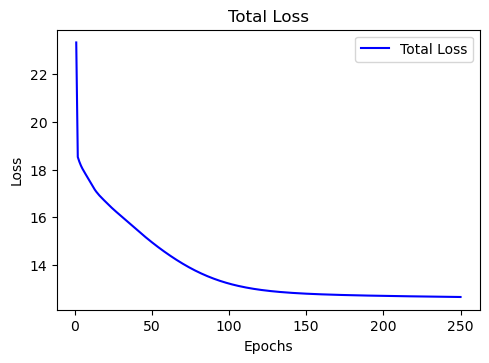

In [20]:
import csv

physics_hyperparam_nopcgrad = [best_result_pareto]
epochs = [250]
lr_schedule = 1e-4
results_nopcgrad = {}
y_differences_nopcgrad = []
total_losses_nopcgrad = []
empirical_losses_nopcgrad = []
physics_losses_nopcgrad = []
all_results_nopcgrad=[]

for epoch in epochs:
        for physics_weight in physics_hyperparam_nopcgrad:
            print("---------- Hyperparameter combinations ------------")
            print("Epoch : {};  physics_weight: {};".format(str(epoch),  str(physics_weight)))

            m = PGGCN_Hybrid()
            m.addRule("sum", 0, 32)
            m.addRule("multiply", 32, 33)
            m.addRule("distance", 33, 36)

            opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
            m.compile(loss=combined_loss(physics_weight), optimizer=opt)

            input_shapes = []
            for i in range(len(X_train)):
                input_shapes.append(np.array(X_train[i]).shape[0])
            m.set_input_shapes(input_shapes)
            for i in range(len(X_train)):
                if X_train[i].shape[0] < 2000:
                    new_list = np.zeros([2000 - X_train[i].shape[0], 53])
                    X_train[i] = np.concatenate([X_train[i], new_list], 0)
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            

            loss_tracker = LossComponentsCallback_Hybrid(m)

            # Add early stopping
            early_stopping = EarlyStopping(
                monitor='loss',           
                patience=10,              
                restore_best_weights=True, 
                min_delta=0.001,          
                verbose=1                 
            )

            hist = m.fit(X_train, y_train, epochs = epoch, batch_size=len(X_train),callbacks=[loss_tracker,early_stopping])


            input_shapes = []
            for i in range(len(X_test)):
                input_shapes.append(np.array(X_test[i]).shape[0])
            m.set_input_shapes(input_shapes)

            for i in range(len(X_test)):
                if X_test[i].shape[0] < 2000:
                    new_list = np.zeros([2000 - X_test[i].shape[0], 53])
                    X_test[i] = np.concatenate([X_test[i], new_list], 0)
            X_test = np.array(X_test)
            x_c = copy.deepcopy(X_test)
            y_test = np.array(y_test)
            y_pred_test = m.predict(X_test)
            y_pred_test = np.array(y_pred_test[:,0])

            y_difference = np.mean(np.abs(y_test - y_pred_test))
            eval = m.evaluate(X_test, y_test)
            print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference)))

            final_train_loss = loss_tracker.total_losses[-1] if loss_tracker.total_losses else None
            
            result_temp = {
                'name':'ΔΔG with Multi-Loss',
                'y_test': y_test,
                'test_loss': eval,
                'y_pred_test': y_pred_test,
                'MAD': y_difference,
                'all_losses': loss_tracker.total_losses,
                'empirical_losses': loss_tracker.empirical_losses if hasattr(loss_tracker, 'empirical_losses') else None,
                'physical_losses': loss_tracker.physical_losses if hasattr(loss_tracker, 'physical_losses') else None,
                'hyperparameters': {
                                    'physics_weight': physics_weight,
                                    'epochs': epoch,
                                    'initial_learning_rate': 0.005,
                                    'decay_steps': 10000,
                                    'decay_rate': 0.9
                }
            }

            
            # Also append to the all_results list for combined saving later
            results_nopcgrad["multi_loss_run"] = result_temp
            all_results_nopcgrad.append(result_temp)
        

        # Plot all loss components over epochs
        plt.figure(figsize=(12, 8))

        epoch_length = range(1, len(loss_tracker.total_losses) + 1)

        # Total loss
        plt.subplot(2, 2, 1)
        plt.plot(epoch_length, loss_tracker.total_losses, 'b-', label='Total Loss')
        plt.title('Total Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        
        with open(outdir/'grid_search_results_no_pcgrad_05.pkl', 'wb') as f:
            pickle.dump({
                'all_results': all_results_nopcgrad,
                'results': results_nopcgrad
            }, f)
        

In [ ]:
plt.subplot(2, 2, 1)
plt.plot(epoch_length, loss_tracker.empirical_losses, 'b-', label='Empirical Loss')
plt.title('Empirical Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
hybrid_y_true = y_test
hybrid_y_pred = y_pred_test

In [ ]:
print(hybrid_y_true)
print(hybrid_y_pred)

In [ ]:
plt.subplot(2, 2, 1)
plt.plot(epoch_length, loss_tracker.physical_losses, 'b-', label='Physical Loss')
plt.title('Physical Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# hist is the History object returned by .fit()
plt.plot(epoch_length, loss_tracker.physical_losses, 'b-', label='Physical Loss')
plt.title('Physical Loss')

plt.xlabel('Epochs')
plt.ylabel('Physical Loss')
plt.legend()
plt.show()

In [ ]:
print(len(loss_tracker.empirical_losses))
print(len(loss_tracker.physical_losses))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Predicted vs.Experimental ΔΔG")
plt.scatter(y_test, y_pred_test, alpha=0.7, color="purple")
plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line
plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.tight_layout()
plt.savefig('Model_Performance_Predicted_vs_Experimental_DDG.png',dpi=100, bbox_inches='tight')
plt.show()

In [21]:
# Comparison Graph Between BFE Loss Function with PCGrad and BFE Loss Function without PCGrad. We are comparing the physical and empirical losses
# and we want to create a table which has empirical loss, physical loss, and MAD comparison

# Extract metrics from PCGrad run
pcgrad_emp_losses = weight_data['empirical_losses'][-1]
pcgrad_phy_losses = weight_data['physical_losses'][-1]
pcgrad_MAD = weight_data['MAD']

# Extract metrics from non-PCGrad run (take last recorded loss values)
no_pcgrad_res = results_nopcgrad["multi_loss_run"]
no_pcgrad_emp = no_pcgrad_res['empirical_losses'][-1] if no_pcgrad_res['empirical_losses'] else None
no_pcgrad_phy = no_pcgrad_res['physical_losses'][-1] if no_pcgrad_res['physical_losses'] else None
no_pcgrad_mad = no_pcgrad_res['MAD']

# Build comparison table
comparison_df = pd.DataFrame({
    "Method": ["With PCGrad", "Without PCGrad"],
    "Empirical Loss": [pcgrad_emp_losses, no_pcgrad_emp],
    "Physics Loss": [pcgrad_phy_losses, no_pcgrad_phy],
    "MAD": [pcgrad_MAD, no_pcgrad_mad]
})

print(comparison_df)


           Method  Empirical Loss  Physics Loss       MAD
0     With PCGrad        3.340216     16.887289  3.063627
1  Without PCGrad        3.260328     17.069279  3.009020


## BFE WITHOUT LOSS

In [ ]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Ids'] == pdb][['pb_host_VDWAALS', 'pb_guest_VDWAALS', 'pb_complex_VDWAALS', 'gb_host_1-4EEL', 'gb_guest_1-4EEL', 'gb_Complex_1-4EEL',
       'gb_host_EELEC', 'gb_guest_EELEC', 'gb_Complex_EELEC', 'gb_host_EGB', 'gb_guest_EGB', 'gb_Complex_EGB', 'gb_host_ESURF', 'gb_guest_ESURF', 'gb_Complex_ESURF']].to_numpy()[0])


In [ ]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Ids'] == pdb]['Ex _G_(kcal/mol)'].to_numpy()[0])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
import models.layers_update_mobley as layers
import importlib
importlib.reload(layers)
import keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping

class PGGCNModel(tf.keras.Model):
    def __init__(self, num_atom_features = 36, r_out_channel = 20, c_out_channel = 128):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1')
        self.dense5 = tf.keras.layers.Dense(16, name='relu')
        self.dense6 = tf.keras.layers.Dense(1, name='dense6')
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                 kernel_initializer=tf.keras.initializers.Constant([.3, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1]),
                 bias_initializer=tf.keras.initializers.Zeros())
        self.all_layer_1_weights = []
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs):
        physics_info = inputs[:,0,38:]
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        #self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        final_weights = mn.ruleGraphConvLayer.w_s  # capture after training

        x = self.conv(x)
        x = self.dense1(x)
        x = self.dense5(x)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out
       
class LossComponentsCallback(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.total_losses = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))

        
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


mn= PGGCNModel()
mn.addRule("sum", 0, 32)
mn.addRule("multiply", 32, 33)
mn.addRule("distance", 33, 36)


# PCGrad optimizer
opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=0.005))

# Preprocess input
input_shapes = [x.shape[0] for x in X_train]
mn.set_input_shapes(input_shapes)

for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        padding = np.zeros([2000 - X_train[i].shape[0], 53])
        X_train[i] = np.concatenate([X_train[i], padding], axis=0)

X_train_nohyb = np.array(X_train).astype(np.float32)
y_train_nohyb = np.array(y_train).astype(np.float32)

# Loss tracking
loss_tracker_nohyb = []
epochs = 400

for ep in range(epochs):
    epoch_start = time.time()

    with tf.GradientTape() as tape:
        preds = mn(X_train_nohyb, training=True)
        loss = pure_rmse(y_train_nohyb, preds)

    grads_and_vars = opt.compute_gradients([loss], tape, mn.trainable_variables)
    opt.apply_gradients(grads_and_vars)

    loss_val = float(loss.numpy())
    loss_tracker_nohyb.append(loss_val)

    epoch_end = time.time()
    duration = epoch_end - epoch_start
    duration_str = f"{duration:.0f}s" if duration > 1 else f"{duration*1000:.0f}ms"

    # Displaying Each epoch one by one seems to take up a lot of time
    # Each epoch takes 90s to run, there are 400 so it would finish in 10 hours
    # Unfortunately it also kills the kernel so running at every 10 for now
    if ep % 10 == 0 or ep == epochs - 1:
        print(f"Epoch {ep+1}/{epochs}")
        print(f"1/1 [==============================] - {duration_str} {duration_str}/step - loss: {loss_val:.4f}")


# Plot
plt.plot(range(1, epochs + 1), loss_tracker_nohyb, label="Empirical Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSE Loss")
plt.title("BFE NoHybrid - PCGrad Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
X_test_nohyb = X_test
y_test_nohyb = y_test
input_shapes = []
for i in range(len(X_test_nohyb)):
    input_shapes.append(np.array(X_test_nohyb[i]).shape[0])
mn.set_input_shapes(input_shapes)

for i in range(len(X_test_nohyb)):
    if X_test_nohyb[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test[i].shape[0], 53])
        X_test_nohyb[i] = np.concatenate([X_test_nohyb[i], new_list], 0)
X_test_nohyb = np.array(X_test_nohyb)
x_c = copy.deepcopy(X_test_nohyb)
y_test_nohyb = np.array(y_test_nohyb)
y_pred_test_nohyb = mn.predict(X_test_nohyb) 
y_pred_test_nohyb = np.array(y_pred_test_nohyb)

y_difference_nohyb = np.mean(np.abs(np.abs(y_test_nohyb) - np.abs(y_pred_test_nohyb)))
eval_nohyb = pure_rmse(y_test_nohyb, y_pred_test_nohyb).numpy()
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference_nohyb)))


result_temp = {
    'name':'ΔΔG with Traditional RMSE',
    'y_test': y_test_nohyb,
    'test_loss': eval_nohyb,
    'y_pred_test': y_pred_test_nohyb,
    'MAD': y_difference_nohyb,
    'all_losses': loss_tracker_nohyb,
    'empirical_losses': None,
    'physical_losses': None,
    'hyperparameters': {
                        'physics_weight': None,
                        'epochs': None,
                        'initial_learning_rate': None,
                        'decay_steps': None,
                        'decay_rate': None
    }
}


# Also append to the all_results list for combined saving later
results["traditional loss"] = result_temp
all_results.append(result_temp)

In [ ]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(loss_tracker_nohyb, label='train loss')

plt.xlabel('Epoch')
plt.ylabel('Pure RMSE Loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Multi-Loss Function vs. Traditional RMSE Approach")
plt.scatter(y_test, hybrid_y_pred, alpha=0.7,color="purple", label = "Multiloss Function")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")
plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line
plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('DDG_Predictions_Multi-Loss_vs_RMSE.png',dpi=100, bbox_inches='tight')
plt.show()

## BFE WITH STRUCTURAL

In [ ]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Ids'] == pdb][['pb_host_VDWAALS', 'pb_guest_VDWAALS', 'pb_complex_VDWAALS', 'gb_host_1-4EEL', 'gb_guest_1-4EEL', 'gb_Complex_1-4EEL',
       'gb_host_EELEC', 'gb_guest_EELEC', 'gb_Complex_EELEC', 'gb_host_EGB', 'gb_guest_EGB', 'gb_Complex_EGB', 'gb_host_ESURF', 'gb_guest_ESURF', 'gb_Complex_ESURF']].to_numpy()[0])


In [ ]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Ids'] == pdb]['Ex _G_(kcal/mol)'].to_numpy()[0])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
import models.layers_update_mobley as layers
import importlib
importlib.reload(layers)
import keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping

class PGGCN_Structural(tf.keras.Model):
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128, l2=1e-4, dropout_rate=0.2, maxnorm=3.0):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense6 = tf.keras.layers.Dense(1, name='dense6', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([.3, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1]),
                                             bias_initializer=tf.keras.initializers.Zeros(),
                                             kernel_regularizer=regularizers.l2(l2), 
                                             bias_regularizer=regularizers.l2(l2), 
                                             kernel_constraint=constraints.MaxNorm(maxnorm))
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs, training=False):
        print("Inside call")
        physics_info = inputs[:, 0, 38:] 
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense5(x)
        x = self.dropout2(x, training=training)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out
    
    
class LossComponentsCallback(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.total_losses = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))

        
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


ms = PGGCN_Structural()
ms.addRule("sum", 0, 32)
ms.addRule("multiply", 32, 33)
ms.addRule("distance", 33, 36)

opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=0.005))

# Preprocess input
input_shapes = [x.shape[0] for x in X_train]
ms.set_input_shapes(input_shapes)

for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        padding = np.zeros([2000 - X_train[i].shape[0], 53])
        X_train[i] = np.concatenate([X_train[i], padding], axis=0)

X_train_struct = np.array(X_train).astype(np.float32)
y_train_struct = np.array(y_train).astype(np.float32)

# Loss tracking
loss_tracker_struct = []

# Manual training loop
epochs = 250
for ep in range(epochs):
    epoch_start = time.time()
    with tf.GradientTape() as tape:
        preds = ms(X_train_struct, training=True)
        loss = pure_rmse(y_train_struct, preds)

    grads_and_vars = opt.compute_gradients([loss], tape, ms.trainable_variables)
    opt.apply_gradients(grads_and_vars)

    loss_val = float(loss.numpy())
    loss_tracker_struct.append(loss_val)

    epoch_end = time.time()
    duration = epoch_end - epoch_start
    duration_str = f"{duration:.0f}s" if duration > 1 else f"{duration*1000:.0f}ms"

    print(f"Epoch {ep+1}/{epochs}")
    print(f"1/1 [==============================] - {duration_str} {duration_str}/step - loss: {loss_val:.4f}")

plt.plot(range(1, epochs + 1), loss_tracker_struct, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSE Loss")
plt.title("BFE Structural - PCGrad Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(loss_tracker_struct, label='train loss')

plt.xlabel('Epoch')
plt.ylabel('RMSE and Structural Loss')
plt.legend()
plt.show()

In [ ]:
X_test_struct = X_test
y_test_struct = y_test
input_shapes = []
for i in range(len(X_test_struct)):
    input_shapes.append(np.array(X_test_struct[i]).shape[0])
ms.set_input_shapes(input_shapes)

for i in range(len(X_test_struct)):
    if X_test_struct[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test_struct[i].shape[0], 53])
        X_test_struct[i] = np.concatenate([X_test_struct[i], new_list], 0)
X_test_struct = np.array(X_test_struct)
x_c = copy.deepcopy(X_test_struct)
y_test_struct = np.array(y_test_struct)
y_pred_test_struct = ms.predict(X_test_struct) 
y_pred_test_struct = np.array(y_pred_test_struct)

y_difference_struct = np.mean(np.abs(np.abs(y_test_struct) - np.abs(y_pred_test_struct)))
#eval_struct = ms.evaluate(X_test_struct, y_test_struct)
eval_struct = pure_rmse(y_test_struct, y_pred_test_struct).numpy()
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference_struct)))


result_temp = {
    'name':'ΔΔG with Structural Loss Function',
    'y_test': y_test_struct,
    'test_loss': eval_struct,
    'y_pred_test': y_pred_test_struct,
    'MAD': y_difference_struct,
    'all_losses': loss_tracker_struct,
    'empirical_losses': None,
    'physical_losses': None,
    'hyperparameters': {
                        'physics_weight': None,
                        'epochs': None,
                        'initial_learning_rate': None,
                        'decay_steps': None,
                        'decay_rate': None
    }
}


# Also append to the all_results list for combined saving later
results["structural loss"] = result_temp
all_results.append(result_temp)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Structural Loss Function vs. Traditional RMSE Approach")
plt.scatter(y_test, y_pred_test_struct, alpha=0.7,color="cyan", label = "Structural Loss")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")

plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line

plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('Model_Performance_Structural_vs_Traditional_DDG.png',dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("ΔΔG Comparison between Traditional Loss, Empirical, Physical and Structural Error")
plt.scatter(y_test, y_pred_test_struct, alpha=0.9,color="blue", label = "Structural Error")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="PURE RMSE")
plt.scatter(y_test, hybrid_y_pred, alpha=0.6,color="purple", label="Multi-Loss")

plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.xlim(-1,12)
plt.ylim(-1, 12)

# Reference y = x line
plt.plot([-1, 12], [-1, 12], color='green', lw=1, linestyle='--')

plt.legend()
plt.tight_layout()

plt.savefig('Emp_Struct_Phy_Loss.png', dpi=100, bbox_inches='tight')
plt.show()

In [43]:
# Save individual run results
individual_filename = f'/home/lvarga57/multiloss-bfe/FINAL-HOSTGUEST-FILES/Result_Pickle/DDG72_test2_Predictions.pkl'
with open(individual_filename, 'wb') as f:
    pickle.dump(results, f)
print(f"Results saved to {individual_filename}")

Results saved to /home/lvarga57/multiloss-bfe/FINAL-HOSTGUEST-FILES/Result_Pickle/DDG72_test2_Predictions.pkl
